In [1]:
#Baseline SVM with PCA classifier

import sklearn
import numpy as np
import sklearn.datasets as skd
import ast
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print("Loading malware training data of 8 families...")
mr_train=skd.load_files('C:/Users/franc/Desktop/Tandon/Spring 2018/ML/Project/dataset/mini_train')
print("Loading malware crossvalidation data of the same 8 families...")
mr_cv=skd.load_files('C:/Users/franc/Desktop/Tandon/Spring 2018/ML/Project/dataset/mini_cv')
print("Loading malware test data with 3 new families...")
mr_test=skd.load_files('C:/Users/franc/Desktop/Tandon/Spring 2018/ML/Project/dataset/mini_test')
print("Preprocessing malware training data...")
b= [eval(s.strip('\n')) for s in mr_train.data]
print("Preprocessing malware crossvalidation data...")
c= [eval(s.strip('\n')) for s in mr_cv.data]
print "Preprocessing malware test data..."
d= [eval(s.strip('\n')) for s in mr_test.data]

dict_vect = DictVectorizer()

print("Vectorizing malware training data...")
x_train = dict_vect.fit_transform(b)
print("Vectorizing malware crossvalidation data...")
x_cv = dict_vect.transform(c)
print("Vectorizing malware test data...")
x_test = dict_vect.transform(d)

print "Training data has %d malware samples and %d features" % (x_train.shape[0], x_train.shape[1])
print "Crossval data has %d malware samples and %d features" % (x_cv.shape[0], x_cv.shape[1])
print "Test data has %d malware samples and %d features" % (x_test.shape[0], x_test.shape[1])

print("Performing PCA on data...")

pca = TruncatedSVD(n_components=1024, algorithm='arpack')
x_train_pca = pca.fit_transform(x_train, mr_train.target)
x_cv_pca = pca.transform(x_cv)
x_test_pca = pca.transform(x_test)

print "After PCA, data has %d features" % (x_train_pca.shape[1])

ker='linear'
c=0.01

print("Training SVM Classifier with %s kernel and %.4f C ..." % (ker,c))
SVM = SVC(C=c,kernel=ker)
SVM.fit(x_train_pca,mr_train.target)

print("Obtaining predictions on test data...")
y_pred_cv=SVM.predict(x_cv_pca)
y_pred_test=SVM.predict(x_test_pca)

prec_cv, rec_cv, fsc_cv, sup_cv = precision_recall_fscore_support(mr_cv.target, y_pred_cv, average='weighted')
prec_test, rec_test, fsc_test, sup_test = precision_recall_fscore_support(mr_test.target, y_pred_test, average='weighted')

print "Precision on crossval data is %.4f" % prec_cv
print "Recall on crossval data is %.4f" % rec_cv
print "Precision on test data is %.4f" % prec_test
print "Recall on test data is %.4f" % rec_test

Loading malware training data of 8 families...
Loading malware crossvalidation data of the same 8 families...
Loading malware test data with 3 new families...
Preprocessing malware training data...
Preprocessing malware crossvalidation data...
Preprocessing malware test data...
Vectorizing malware training data...
Vectorizing malware crossvalidation data...
Vectorizing malware test data...
Training data has 2277 malware samples and 337610 features
Crossval data has 489 malware samples and 337610 features
Test data has 568 malware samples and 337610 features
Performing PCA on data...
After PCA, data has 1024 features
Training SVM Classifier with linear kernel and 0.0100 C ...
Obtaining predictions on test data...


C:\Users\franc\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision on crossval data is 0.9734
Recall on crossval data is 0.9714
Precision on test data is 0.7636
Recall on test data is 0.8504


In [2]:
#Distance measure to hyperplanes
print "Computing mean distance of training samples of each class to their hyperplane"
t=np.array([])
m=np.array([])
std=np.array([])
alpha=1
for i in range(len(mr_train.target_names)):
    m= np.append(m,np.mean(SVM.decision_function(x_train_pca)[np.argmax(SVM.decision_function(x_train_pca),axis=1)==i][:,i]))
    std = np.append(std,np.std(SVM.decision_function(x_train_pca)[np.argmax(SVM.decision_function(x_train_pca),axis=1)==i][:,i]))
    t=np.append(t,m[i]-alpha*std[i])
    
print "Finding and selecting drifted objects in test set based on thresholds"
ind_drift_hyp=np.array([])
for i in range(len(mr_train.target_names)):    
    ind_drift_hyp = np.append(ind_drift_hyp,np.flatnonzero(np.argmax(SVM.decision_function(x_test_pca),axis=1)==i)[np.flatnonzero([SVM.decision_function(x_test_pca)[np.where(np.argmax(SVM.decision_function(x_test_pca),axis=1)==i),i]<t[i]][0][0]==True)])

ind_drift_hyp=ind_drift_hyp.astype(int)

print "Total drifted samples in test set: %d out of %d samples" % (ind_drift_hyp.size,len(mr_test.data))
print "Percentage of drifted samples in test set: %.4f" % (np.double(ind_drift_hyp.size)/len(mr_test.data))

print "Relabelling drifted samples, and retraining SVM..."
x_train_drift_hyp_drift = np.append(x_train_pca,x_test_pca[ind_drift_hyp],axis=0)
mr_train_drift_hyp_drift = np.append(mr_train.target,mr_test.target[ind_drift_hyp],axis=0)
SVM_drift_hyp = SVC(C=c,kernel=ker)
SVM_drift_hyp.fit(x_train_drift_hyp_drift,mr_train_drift_hyp_drift)

print "Computing predictions on test data with newly trained model..."
y_drift_hyp = SVM_drift_hyp.predict(x_test_pca)

prec_drift_hyp, rec_drift_hyp, fsc_drift_hyp, sup_drift_hyp = precision_recall_fscore_support(mr_test.target,y_drift_hyp, average='weighted')

print "Precision on test data with new classes with original model was %.4f" %prec_test
print "Recall on test data with new classes with original model was %.4f" %rec_test
print "Precision on test data with new classes with concept drift-aware model %.4f" %prec_drift_hyp
print "Recall on test data with new classes with concept drift-aware model %.4f" %rec_drift_hyp

Computing mean distance of training samples of each class to their hyperplane
Finding and selecting drifted objects in test set based on thresholds
Total drifted samples in test set: 91 out of 568 samples
Percentage of drifted samples in test set: 0.1602
Relabelling drifted samples, and retraining SVM...
Computing predictions on test data with newly trained model...
Precision on test data with new classes with original model was 0.7636
Recall on test data with new classes with original model was 0.8504
Precision on test data with new classes with concept drift-aware model 0.9845
Recall on test data with new classes with concept drift-aware model 0.9842


In [4]:
#Distance measure to class centroids

print "Finding class centroids and computing distance of samples to centroids"
clf = NearestCentroid()
clf.fit(x_train_pca,mr_train.target)

dist_train = pairwise_distances(x_train_pca, clf.centroids_)
dist_test = pairwise_distances(x_test_pca, clf.centroids_)

print "Calculating drift_l2 thresholds..."
m = np.resize(np.array([]),8)
var = np.resize(np.array([]),8)
thresh = np.resize(np.array([]),8)
for i in range(8):
    m[i] = np.mean(dist_train[np.where(np.argmin(dist_train,axis=1)==i)][:,i])
    var[i] = np.sqrt(np.std(dist_train[np.where(np.argmin(dist_train,axis=1)==i)][:,i]))
    thresh[i] = m[i]+var[i] 
    

test_drift_l2 = np.resize(np.array([]),8)
test_total = np.resize(np.array([]),8)
test_d_per = np.resize(np.array([]),8)

"Calculating drift_l2 on test data with new classes..."
for r in range(8):
    test_drift_l2[r]=sum(dist_test[np.where(np.argmin(dist_test,axis=1)==r)][:,r] > thresh[r])
    test_total[r]= sum(np.argmin(dist_test,axis=1)==r)
    if test_total[r]!=0:
        test_d_per[r]=test_drift_l2[r]/test_total[r]
    else:
        test_d_per[r]='nan'
        
print "In test set there are %d drift_l2ed malware of a total of %d samples, total drift_l2 percentage is %.4f" % (sum(test_drift_l2), sum(test_total), sum(test_drift_l2)/sum(test_total))

print "Selecting drift_l2ed malware samples from test set..."
ind_array_test = np.array([])
indices_test = np.array([])

for i in range(8):
    ind_array_test = np.where(np.argmin(dist_test,axis=1)==i)
    indices_test = np.append(indices_test,ind_array_test[0][dist_test[np.where(np.argmin(dist_test,axis=1)==i)][:,i] > thresh[i]])

print "Appending drift_l2ed malware samples from test set to training set, and re-labelling..."
x_train_drift_l2 = np.append(x_train_pca,x_test_pca[indices_test.astype(int)],axis=0)
mr_train_drift_l2_target = np.append(mr_train.target,mr_test.target[indices_test.astype(int)],axis=0)

print "Training drift_l2-Aware SVM classifier with new training set..."
SVM_drift_l2 = SVC(C=c,kernel=ker)
SVM_drift_l2.fit(x_train_drift_l2,mr_train_drift_l2_target)

print "Computing predictions on test data with newly trained model..."
y_drift_l2 = SVM_drift_l2.predict(x_test_pca)

prec_drift_l2, rec_drift_l2, fsc_drift_l2, sup_drift_l2 = precision_recall_fscore_support(mr_test.target,y_drift_l2, average='weighted')

print "Precision on test data with new classes with original model was %.4f" %prec_test
print "Recall on test data with new classes with original model was %.4f" %rec_test
print "Precision on test data with new classes with concept drift_l2-aware model %.4f" %prec_drift_l2
print "Recall on test data with new classes with concept drift_l2-aware model %.4f" %rec_drift_l2


Finding class centroids and computing distance of samples to centroids
Calculating drift_l2 thresholds...
In test set there are 148 drift_l2ed malware of a total of 568 samples, total drift_l2 percentage is 0.2606
Selecting drift_l2ed malware samples from test set...
Appending drift_l2ed malware samples from test set to training set, and re-labelling...
Training drift_l2-Aware SVM classifier with new training set...
Computing predictions on test data with newly trained model...
Precision on test data with new classes with original model was 0.7636
Recall on test data with new classes with original model was 0.8504
Precision on test data with new classes with concept drift_l2-aware model 0.9274
Recall on test data with new classes with concept drift_l2-aware model 0.9349


In [9]:
# Computing intersections of flagged samples and actual new class samples for hyperplane drift
intersection = np.intersect1d(np.sort(ind_drift_hyp),np.flatnonzero(mr_test.target > 7))
print intersection.shape
print "Precision with alpha = %d is %.4f, recall is %.4f, flagged samples are %d, percentage of samples flagged is %.4f and percentage of flagged samples that actually belong to new families is %.4f" % (alpha,prec_drift_hyp,rec_drift_hyp,len(ind_drift_hyp),np.double(len(ind_drift_hyp))/np.double(len(mr_test.data)),np.double(intersection.shape[0])/np.double(np.flatnonzero(mr_test.target > 7).size))


(70L,)
Precision with alpha = 1 is 0.9845, recall is 0.9842, flagged samples are 91, percentage of samples flagged is 0.1602 and percentage of flagged samples that actually belong to new families is 0.9091


In [12]:
# Computing intersections of flagged samples and actual new class samples for l2 centroid drift
intersection = np.intersect1d(np.sort(indices_test),np.flatnonzero(mr_test.target > 7))
print intersection.shape
print "Precision with mean + 1std threshold is %.4f, recall is %.4f, flagged samples are %d, percentage of samples flagged is %.4f and percentage of flagged samples that actually belong to new families is %.4f" % (prec_drift_l2,rec_drift_l2,len(indices_test),np.double(len(indices_test))/np.double(len(mr_test.data)),np.double(intersection.shape[0])/np.double(np.flatnonzero(mr_test.target > 7).size))


(23L,)
Precision with mean + 1std threshold is 0.9274, recall is 0.9349, flagged samples are 148, percentage of samples flagged is 0.2606 and percentage of flagged samples that actually belong to new families is 0.2987


Computing confusion matrices...
Plotting confusion matrix for crossvalidation data
Confusion matrix, without normalization
[[ 27   0   0   0   0   0   1   0]
 [  0 149   1   0   0   0   0   0]
 [  0   1  30   0   0   1   1   0]
 [  0   0   1  49   0   3   0   0]
 [  0   0   0   0  18   0   0   0]
 [  0   0   0   0   0  40   0   0]
 [  0   0   4   0   0   1 145   0]
 [  0   0   0   0   0   0   0  17]]
Normalized confusion matrix
[[0.96 0.   0.   0.   0.   0.   0.04 0.  ]
 [0.   0.99 0.01 0.   0.   0.   0.   0.  ]
 [0.   0.03 0.91 0.   0.   0.03 0.03 0.  ]
 [0.   0.   0.02 0.92 0.   0.06 0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.03 0.   0.   0.01 0.97 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.  ]]


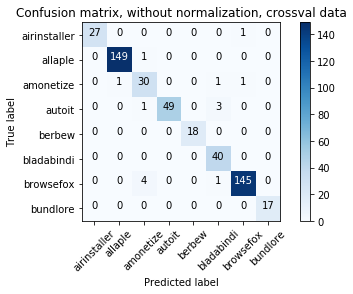

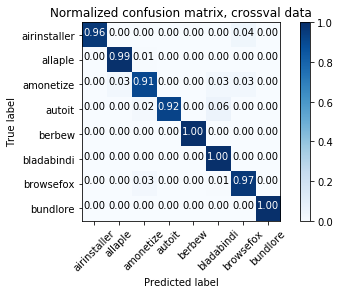

Plotting confusion matrix for test data in base model
Confusion matrix, without normalization
[[ 27   1   0   0   0   0   0   0   0   0   0]
 [  0 150   0   0   0   0   0   0   0   0   0]
 [  1   0  31   0   0   0   0   0   0   0   0]
 [  0   0   1  52   0   1   0   0   0   0   0]
 [  0   0   0   0  18   0   0   0   0   0   0]
 [  0   0   1   0   0  40   0   0   0   0   0]
 [  0   0   3   0   0   0 147   0   0   0   0]
 [  0   0   0   0   0   0   0  18   0   0   0]
 [  0   0  15   0   0   0   0   0   0   0   0]
 [  0  10   6   5   1   0   2   0   0   0   0]
 [  8   1  11   1   0  16   1   0   0   0   0]]
Normalized confusion matrix
[[0.96 0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.03 0.   0.97 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.02 0.96 0.   0.02 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.02 0.   0.   0.98 0.   0.   0.   0.   0.  ]
 [0.   0.   

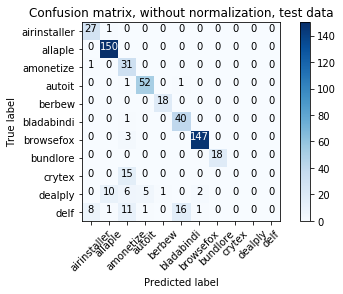

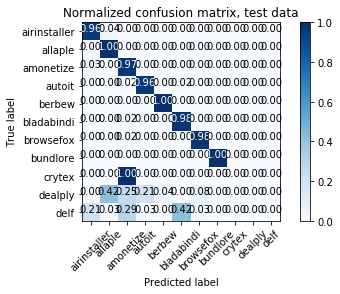

Plotting confusion matrix for test data in drift-aware hyperplane model
Confusion matrix, without normalization
[[ 27   1   0   0   0   0   0   0   0   0   0]
 [  0 150   0   0   0   0   0   0   0   0   0]
 [  0   0  32   0   0   0   0   0   0   0   0]
 [  0   0   0  54   0   0   0   0   0   0   0]
 [  0   0   0   0  18   0   0   0   0   0   0]
 [  0   0   0   0   0  41   0   0   0   0   0]
 [  0   0   0   0   0   2 146   0   1   0   1]
 [  0   0   0   0   0   0   0  18   0   0   0]
 [  0   0   0   0   0   0   0   0  15   0   0]
 [  0   1   0   0   0   0   0   0   0  23   0]
 [  0   1   1   0   0   0   0   0   0   1  35]]
Normalized confusion matrix
[[0.96 0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   

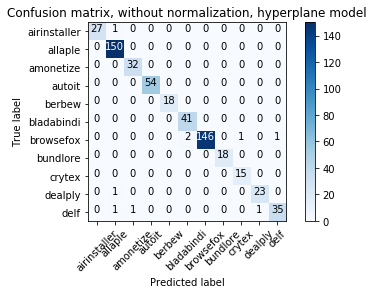

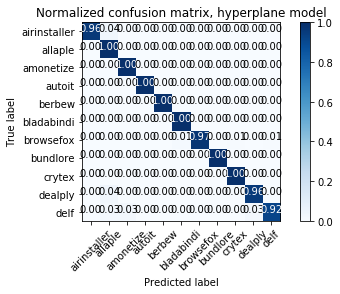

Plotting confusion matrix for test data in drift-aware l2 model
Confusion matrix, without normalization
[[ 27   1   0   0   0   0   0   0   0   0   0]
 [  0 150   0   0   0   0   0   0   0   0   0]
 [  0   0  32   0   0   0   0   0   0   0   0]
 [  0   0   0  54   0   0   0   0   0   0   0]
 [  0   0   0   0  18   0   0   0   0   0   0]
 [  0   0   1   0   0  40   0   0   0   0   0]
 [  0   0   3   0   0   0 147   0   0   0   0]
 [  0   0   0   0   0   0   0  18   0   0   0]
 [  0   0  13   0   0   0   2   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0  23   0]
 [  0   0   6   1   0   0   3   0   0   6  22]]
Normalized confusion matrix
[[0.96 0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.02 0.   0.   0.98 0.   0.   0.   0.   0.  ]
 [

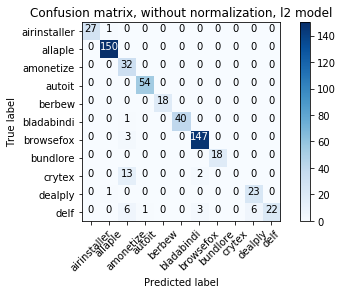

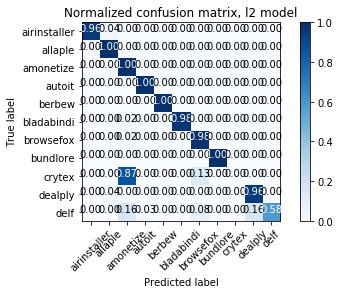

In [17]:
y_drift_l2 = SVM_drift_l2.predict(x_test_pca)
y_drift_hyp = SVM_drift_hyp.predict(x_test_pca)

#Confusion Matrices

print "Computing confusion matrices..."
cnf_matrix_cv = confusion_matrix(mr_cv.target, y_pred_cv)
cnf_matrix_test = confusion_matrix(mr_test.target,y_pred_test)
cnf_matrix_drift_hyp = confusion_matrix(mr_test.target,y_drift_hyp)
cnf_matrix_drift_l2 = confusion_matrix(mr_test.target,y_drift_l2)


print "Plotting confusion matrix for crossvalidation data"
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_cv, classes=mr_cv.target_names,
                      title='Confusion matrix, without normalization, crossval data')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_cv, classes=mr_cv.target_names, normalize=True,
                      title='Normalized confusion matrix, crossval data')

plt.show()

print "Plotting confusion matrix for test data in base model"
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_test, classes=mr_test.target_names,
                      title='Confusion matrix, without normalization, test data')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_test, classes=mr_test.target_names, normalize=True,
                      title='Normalized confusion matrix, test data')

plt.show()

print "Plotting confusion matrix for test data in drift-aware hyperplane model"
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_drift_hyp, classes=mr_test.target_names,
                      title='Confusion matrix, without normalization, hyperplane model')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_drift_hyp, classes=mr_test.target_names, normalize=True,
                      title='Normalized confusion matrix, hyperplane model')

plt.show()

print "Plotting confusion matrix for test data in drift-aware l2 model"
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_drift_l2, classes=mr_test.target_names,
                      title='Confusion matrix, without normalization, l2 model')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_drift_l2, classes=mr_test.target_names, normalize=True,
                      title='Normalized confusion matrix, l2 model')

plt.show()